# Fine-tune GPT Model

- We'll be finetuning the LLM on a specific target task, such as classifying text.

In [1]:
%load_ext watermark
%watermark -v -p numpy,pandas,polars,torch,lightning --conda

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

numpy    : 1.26.4
pandas   : 2.2.1
polars   : 0.20.18
torch    : 2.2.2
lightning: 2.2.1

conda environment: torch_p11



In [2]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt


# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F

In [4]:
GPT_CONFIG_124M: dict[str, Any] = {
    "vocab_size": 50_257,
    "context_length": 1_024,
    "emb_dim": 768,
    "n_heads": 12,  # Number of attention heads
    "n_layers": 12,
    "drop_rate": 0.1,  # Dropout rate
    "qkv_bias": False,
}

### Dataset Download

In [5]:
from urllib import request
import zipfile
import os


def download_and_unzip_spam_data(
    url: str, zip_path: str, extracted_path: str, data_file_path: Path
) -> None:
    original_file_path: Path = Path(extracted_path) / "SMSSpamCollection"

    if data_file_path.exists():
        console.print(
            f"{str(data_file_path)!r} already exists. Skipping download and extraction."
        )
        return None

    # Download the file to the specified directory
    with request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzip the file to the specified directory
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    os.rename(original_file_path, data_file_path)
    console.print(f"File downloaded and saved as {data_file_path!r}")
    return None

In [6]:
url: str = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path: str = "sms_spam_collection.zip"
extracted_path: str = "sms_spam_collection"
data_file_path: Path = Path(extracted_path) / "SMSSpamCollection.tsv"


download_and_unzip_spam_data(
    url=url,
    zip_path=zip_path,
    extracted_path=extracted_path,
    data_file_path=data_file_path,
)

'sms_spam_collection/SMSSpamCollection.tsv' already exists. Skipping download and extraction.

In [7]:
df: pl.DataFrame = pl.read_csv(
    source=data_file_path,
    separator="\t",
    has_header=False,
).rename({"column_1": "Label", "column_2": "Text"})

print(f"{df.shape[0]:,} rows")
df.head()

5,278 rows


Label,Text
str,str
"""ham""","""Go until juron…"
"""ham""","""Ok lar... Joki…"
"""spam""","""Free entry in …"
"""ham""","""U dun say so e…"
"""ham""","""Nah I don't th…"


In [8]:
df.group_by("Label").agg(pl.len())

Label,len
str,u32
"""ham""",4581
"""spam""",697


In [9]:
def generate_sample_data(
    data: pl.DataFrame, seed: int = 123, print_shape: bool = False
) -> pl.DataFrame:

    sample_size: int = int(data.filter(pl.col("Label").eq("spam")).shape[0] * 1.0)
    print(f"sample_size: {sample_size:,}")
    spam: pl.DataFrame = data.filter(pl.col("Label").eq("spam"))
    ham: pl.DataFrame = data.filter(pl.col("Label").eq("ham")).sample(
        n=sample_size, seed=seed
    )
    data_df: pl.DataFrame = pl.concat([spam, ham], how="vertical").sample(
        seed=seed, fraction=1, shuffle=True
    )
    if print_shape:
        print(f"Data shape: {data_df.shape[0]:,} rows")

    return data_df

In [10]:
seed: int = 123

data = generate_sample_data(data=df, seed=seed, print_shape=True)
data.head()

sample_size: 697
Data shape: 1,394 rows


Label,Text
str,str
"""ham""","""I'm in a meeti…"
"""ham""","""Wah... Okie ok…"
"""ham""","""Ok then i come…"
"""ham""","""Ok lor. Msg me…"
"""spam""","""Sexy Singles a…"


In [11]:
data.group_by("Label").agg(pl.len())

Label,len
str,u32
"""spam""",697
"""ham""",697


In [12]:
# Encode the labels
data = data.with_columns(
    Label=pl.when(pl.col("Label").eq("ham")).then(pl.lit(0)).otherwise(pl.lit(1))
)

console.print(data.head())

shape: (5, 2)
┌───────┬───────────────────────────────────┐
│ Label ┆ Text                              │
│ ---   ┆ ---                               │
│ i32   ┆ str                               │
╞═══════╪═══════════════════════════════════╡
│ 0     ┆ I'm in a meeting, call me later … │
│ 0     ┆ Wah... Okie okie... Muz make use… │
│ 0     ┆ Ok then i come n pick u at engin… │
│ 0     ┆ Ok lor. Msg me b4 u call.         │
│ 1     ┆ Sexy Singles are waiting for you… │
└───────┴───────────────────────────────────┘

In [13]:
## Split the data into tran, validation and test sets
from sklearn.model_selection import train_test_split


train_data: pl.DataFrame
val_data: pl.DataFrame
test_data: pl.DataFrame

train_data, test_data = train_test_split(
    data, stratify=data.select("Label"), test_size=0.1, random_state=seed
)
train_data, val_data = train_test_split(
    train_data, stratify=train_data.select("Label"), test_size=0.1, random_state=seed
)

print(f"{train_data.shape = }, {val_data.shape = }, {test_data.shape = }")

train_data.shape = (1128, 2), val_data.shape = (126, 2), test_data.shape = (140, 2)


In [14]:
# Save the data
save_path: Path = Path("../../data/sms_data")
train_data.write_parquet(file=save_path / "train.parquet", use_pyarrow=True)
val_data.write_parquet(file=save_path / "val.parquet", use_pyarrow=True)
test_data.write_parquet(file=save_path / "test.parquet", use_pyarrow=True)

print(train_data.group_by("Label").agg(pl.len()))
print(val_data.group_by("Label").agg(pl.len()))
print(test_data.group_by("Label").agg(pl.len()))

shape: (2, 2)
┌───────┬─────┐
│ Label ┆ len │
│ ---   ┆ --- │
│ i32   ┆ u32 │
╞═══════╪═════╡
│ 1     ┆ 564 │
│ 0     ┆ 564 │
└───────┴─────┘
shape: (2, 2)
┌───────┬─────┐
│ Label ┆ len │
│ ---   ┆ --- │
│ i32   ┆ u32 │
╞═══════╪═════╡
│ 0     ┆ 63  │
│ 1     ┆ 63  │
└───────┴─────┘
shape: (2, 2)
┌───────┬─────┐
│ Label ┆ len │
│ ---   ┆ --- │
│ i32   ┆ u32 │
╞═══════╪═════╡
│ 1     ┆ 70  │
│ 0     ┆ 70  │
└───────┴─────┘


### Create Datasets And Data Loaders

- Pad all the texts to the same length.
- Pad using the index of the pad token.
  - `"<|endoftext|>"` is the padding token.
  - it has an index of 50256 (using tiktoken)

In [15]:
from torch.utils.data import Dataset, DataLoader


class SpamDataset(Dataset):
    def __init__(
        self,
        data: pl.DataFrame,
        tokenizer: Any,
        max_length: int | None = None,
        pad_token: int = 50_256,
    ) -> None:
        self.data = data
        self.encoded_texts: list[int] = [
            tokenizer.encode(text) for text in self.data.select("Text").to_series()
        ]

        if max_length is None:
            self.max_length: int = self._calculate_max_length()
        else:
            assert (
                max_length > 0
            ), "max_length must be a positive integer or None, not a negative integer."
            self.max_length = max_length

        # Truncate text
        self.encoded_texts = [
            tok_ids[: self.max_length] for tok_ids in self.encoded_texts
        ]
        # Pad Text
        self.encoded_texts = [
            tok_ids + [pad_token] * (self.max_length - len(tok_ids))
            for tok_ids in self.encoded_texts
        ]
        # Targets
        self.targets: list[int] = self.data.select("Label").to_series().to_list()

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        text: Tensor = torch.tensor(self.encoded_texts[idx], dtype=torch.long)
        label: Tensor = torch.tensor(self.targets[idx], dtype=torch.long)

        return (text, label)

    def _calculate_max_length(self) -> int:
        return max([len(tok_ids) for tok_ids in self.encoded_texts])

In [16]:
# Test the dataset implementation
import tiktoken


torch.manual_seed(123)
tokenizer = tiktoken.get_encoding("gpt2")
sample_dataset: Dataset = SpamDataset(data=train_data, tokenizer=tokenizer)

sample_dataset[2]

(tensor([   42,    13,    74,   492,  4919,   318,   534,  6621,  3988,    30,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 5

In [17]:
train_dataset: Dataset = SpamDataset(data=train_data, tokenizer=tokenizer)
val_dataset: Dataset = SpamDataset(
    data=val_data, tokenizer=tokenizer, max_length=train_dataset.max_length
)
test_dataset: Dataset = SpamDataset(
    data=test_data, tokenizer=tokenizer, max_length=train_dataset.max_length
)


# Create data loaders
batch_size: int = 8
num_workers: int = 0

train_loader: DataLoader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)
val_loader: DataLoader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False,
)
test_loader: DataLoader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False,
)

In [18]:
for inp_batch, target_batch in train_loader:
    print(f"{inp_batch.shape = }")
    print(f"{target_batch.shape = }\n\n")

    break


print(f"{len(train_loader) = }")
print(f"{len(val_loader) = }")
print(f"{len(test_loader) = }")

inp_batch.shape = torch.Size([8, 188])
target_batch.shape = torch.Size([8])


len(train_loader) = 141
len(val_loader) = 16
len(test_loader) = 18


<hr>

### Load Pretrained Model

In [19]:
# Model Config
MODEL_CHOICE: str = "gpt2-small (124M)"
INPUT_PROMPT: str = "Every effort moves"
BASE_CONFIG = {
    "vocab_size": 50_257,  # Vocabulary size
    "context_length": 1_024,  # Context length
    "drop_rate": 0.0,  # Dropout rate
    "qkv_bias": True,  # Query-key-value bias
}
model_configs: dict[str, dict] = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[MODEL_CHOICE])

assert train_dataset.max_length <= BASE_CONFIG.get("context_length"), (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG.get('context_length')}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG.get('context_length')}`"
)

In [20]:
from gpt_download import download_and_load_gpt2
from utils import GPTModel, load_weights_into_gpt


model_size: str = MODEL_CHOICE.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(gpt=model, params=params)
model.eval()

2024-06-22 13:56:13.996155: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (dropout): Dropout(p=0.0, inplace=False)
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (dropout): Dropout(p=0.0, inpla

In [21]:
from gpt_generate import generate_text_simple, text_to_token_ids, token_ids_to_text


text_1: str = "Every effort moves you"
token_ids: Tensor = generate_text_simple(
    model=model,
    input_idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_length=BASE_CONFIG["context_length"],
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you forward.

The first step is to understand the importance of your work


In [22]:
text_2: str = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)
token_ids: Tensor = generate_text_simple(
    model=model,
    input_idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=15,
    context_length=BASE_CONFIG["context_length"],
)
# The model struggles because it hasn't be trained on the task (instruction) yet.
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or


### Add A Classification Head

- Replace the head of the model (**`model.out_head`**) with a classification head.
- i.e. the model is currently output a vector of size `50,257` (vocab size) and should be replaced with a head that outputs a vector of size `2` (number of classes).
<br>

<img src="./images/ch06_classif_head.png" width="700">

[image source](https://livebook.manning.com/book/build-a-large-language-model-from-scratch/chapter-6/v-7/105)


- `Finetuning pretrained` language models doesn't require updating all layers because:
  - Lower layers capture general language structures applicable to many tasks.
  - Upper layers are more task-specific and adapt to nuanced patterns.
  - Updating only upper layers is often sufficient for new tasks.
  - This approach is computationally more efficient.

- This technique leverages transfer learning, allowing models to adapt quickly to new tasks while preserving foundational language knowledge.

<br>

```text
GPTModel(
    (tok_emb): Embedding(50257, 768)
    (pos_emb): Embedding(1024, 768)
    (drop_emb): Dropout(p=0.0, inplace=False)
    (trf_blocks): Sequential(
      (0): TransformerBlock(

    ...
  
      (11): TransformerBlock(
        (att): MultiHeadAttention(
          (dropout): Dropout(p=0.0, inplace=False)
          (W_query): Linear(in_features=768, out_features=768, bias=True)
          (W_key): Linear(in_features=768, out_features=768, bias=True)
          (W_value): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ff): FeedForward(
          (layers): Sequential(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU()
            (2): Linear(in_features=3072, out_features=768, bias=True)
          )
        )
        (norm1): LayerNorm()
        (norm2): LayerNorm()
        (drop_shortcut): Dropout(p=0.0, inplace=False)
      )
    )
    (final_norm): LayerNorm()
    (out_head): Linear(in_features=768, out_features=50257, bias=False)
  )
)
```

In [23]:
# To get the model ready for fine-tuning, we need to `freeze` the model's parameters.
for param in model.parameters():
    param.requires_grad = False

In [24]:
# Replace the output layer which originally maps the layer inputs to 50,257 dimensions
# to the number of classes.
torch.manual_seed(seed)
num_classes: int = 2

model.out_head = nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)


# Make the last `transformer block` layer trainable
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

# Make the last `final_norm` layer trainable
for param in model.final_norm.parameters():
    param.requires_grad = True

In [25]:
model

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (dropout): Dropout(p=0.0, inplace=False)
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (dropout): Dropout(p=0.0, inpla

In [26]:
inputs: list[int] = tokenizer.encode("Do you have time")
inputs: Tensor = torch.tensor(inputs).unsqueeze(0)
print(f"Inputs: {inputs}")

# shape: (batch_size, num_tokens)
print(f"Inputs dimensions: {tuple(inputs.shape)}")

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: (1, 4)


In [27]:
# Pass the encoded input to the model
with torch.no_grad():
    logits: Tensor = model(inputs)
print(f"Oututs: {logits}")

# shape: (batch_size, num_tokens, num_classes)
print(f"Outputs dimensions: {tuple(logits.shape)}")

Oututs: tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2660,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: (1, 4, 2)


#### Comment

- For a spam classification task:
  - We're finetuning the model to output a binary label (spam/not spam).
  - We don't need to finetune all output rows of the model.
  - We can focus on a single output token.
  - Specifically, we'll use the last row corresponding to the final output token.

- This approach simplifies the finetuning process by concentrating on the most relevant part of the model's output for our classification task.

In [28]:
# Final output token
output_logit: Tensor = logits[:, -1, :]
proba: Tensor = torch.softmax(output_logit, dim=-1)
result: int = torch.argmax(proba, dim=-1, keepdim=True).item()

print(f"{output_logit = }\n{proba = } \n")
print(result)

output_logit = tensor([[-3.5983,  3.9902]])
proba = tensor([[5.0600e-04, 9.9949e-01]]) 

1


In [29]:
def calc_accuracy_loader(
    data_loader: DataLoader,
    model: nn.Module,
    device: torch.device,
    num_batches: int | None = None,
) -> float:
    """Calculates the accuracy of a model on a given data loader.

    Args:
        data_loader (torch.utils.data.DataLoader): The data loader containing the input data and target labels.
        model (torch.nn.Module): The model to be evaluated.
        device (torch.device): The device (CPU or GPU) to use for the evaluation.
        num_batches (int, optional): The maximum number of batches to evaluate. If None, all batches in the data
        loader will be used.

    Returns:
        float: The accuracy of the model on the data loader.
    """
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits: Tensor = model(input_batch)[:, -1, :]
            predicted_labels: Tensor = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples


def calc_loss_batch(
    input_batch: Tensor, target_batch: Tensor, model: nn.Module, device: torch.device
) -> Tensor:
    """Calculates the loss for a batch of input and target data using the given model.

    Args:
        input_batch (torch.Tensor): The input batch of data.
        target_batch (torch.Tensor): The target batch of labels.
        model (torch.nn.Module): The model to be used for the loss calculation.
        device (torch.device): The device (CPU or GPU) to use for the calculation.

    Returns:
        torch.Tensor: The loss value for the batch.
    """
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    # Logits of the final output token
    logits: Tensor = model(input_batch)[:, -1, :]
    loss: Tensor = F.cross_entropy(logits, target_batch)
    return loss


def calc_loss_loader(
    data_loader: DataLoader,
    model: nn.Module,
    device: torch.device,
    num_batches: int | None = None,
):
    """Calculates the average loss across a data loader for a given model.

    Args:
        data_loader (torch.utils.data.DataLoader): The data loader containing the input and target data.
        model (torch.nn.Module): The model to be used for the loss calculation.
        device (torch.device): The device (CPU or GPU) to use for the calculation.
        num_batches (int, optional): The maximum number of batches to evaluate. If None, all batches in the data
            loader will be used.

    Returns:
        float: The average loss of the model on the data loader.
    """
    total_loss: float = 0.0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss: Tensor = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

### Comment

- The predictions are random at best (~50%) because the model hasn't been fine-tuned yet.

In [30]:
torch.manual_seed(123)

device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_accuracy: float = calc_accuracy_loader(
    train_loader, model, device, num_batches=10
)
val_accuracy: float = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy: float = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 51.25%
Validation accuracy: 51.25%
Test accuracy: 51.25%


In [31]:
# Similar to calculating the training accuracy, we now compute the initial loss for each data set:
with torch.no_grad():
    train_loss: float = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss: float = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss: float = calc_loss_loader(test_loader, model, device, num_batches=5)


print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.412
Validation loss: 2.797
Test loss: 2.526


<hr>

### Finetune The Model

- The [figure](https://livebook.manning.com/book/build-a-large-language-model-from-scratch/chapter-6/v-7/181) below shows the training loop.

<img src="./images/ch06_training_loop.png" width="700">

In [32]:
def evaluate_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: torch.device,
    eval_iter: int,
) -> tuple[float, float]:
    """
    Evaluates the performance of the given model on the training and validation data.

    Args:
        model (nn.Module): The model to evaluate.
        train_loader (DataLoader): The training data loader.
        val_loader (DataLoader): The validation data loader.
        device (torch.device): The device to use for evaluation (CPU or GPU).
        eval_iter (int): The number of evaluation iterations to run.

    Returns:
        tuple: A tuple containing the following:
            - train_loss (float): The average training loss.
            - val_loss (float): The average validation loss.
    """
    model.eval()  # Set the model to evaluation mode.

    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)

    model.train()  # Reset the model to training mode.

    return (train_loss, val_loss)


def train_classifier_simple(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    num_epochs: int,
    eval_freq: int,
    eval_iter: int,
    tokenizer: Any,
) -> tuple[list[float] | int, ...]:
    """
    Trains a simple classifier model on the provided training and validation data.

    Args:
        model (nn.Module): The classifier model to train.
        train_loader (DataLoader): The training data loader.
        val_loader (DataLoader): The validation data loader.
        optimizer (Optimizer): The optimizer to use for training.
        device (torch.device): The device to use for training (CPU or GPU).
        num_epochs (int): The number of training epochs.
        eval_freq (int): The frequency (in steps) to evaluate the model on the validation set.
        eval_iter (int): The number of validation iterations to run.
        tokenizer (Tokenizer): The tokenizer to use for the input data.

    Returns:
        tuple: A tuple containing the following:
            - train_losses (list): The training losses for each evaluation step.
            - val_losses (list): The validation losses for each evaluation step.
            - train_accs (list): The training accuracies for each epoch.
            - val_accs (list): The validation accuracies for each epoch.
            - examples_seen (int): The total number of training examples seen.
    """
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode.

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            examples_seen += input_batch.shape[0]
            global_step += 1

            # Optional: Evaluate after each batch
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}"
                )

        # Calculate the accuracy after each epoch
        train_accuracy = calc_accuracy_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_accuracy = calc_accuracy_loader(
            val_loader, model, device, num_batches=eval_iter
        )

        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [33]:
import time


torch.manual_seed(seed)

num_epochs: int = 5
start_time: float = time.time()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=50,
    eval_iter=5,
    tokenizer=tokenizer,
)

end_time: float = time.time()
execution_time_minutes: float = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.704, Val loss 2.571
Ep 1 (Step 000050): Train loss 0.627, Val loss 0.554
Ep 1 (Step 000100): Train loss 0.526, Val loss 0.503
Training accuracy: 72.50% | Validation accuracy: 80.00%
Ep 2 (Step 000150): Train loss 0.478, Val loss 0.420
Ep 2 (Step 000200): Train loss 0.524, Val loss 0.434
Ep 2 (Step 000250): Train loss 0.230, Val loss 0.358
Training accuracy: 82.50% | Validation accuracy: 82.50%
Ep 3 (Step 000300): Train loss 0.384, Val loss 0.415
Ep 3 (Step 000350): Train loss 0.158, Val loss 0.238
Ep 3 (Step 000400): Train loss 0.188, Val loss 0.130
Training accuracy: 85.00% | Validation accuracy: 92.50%
Ep 4 (Step 000450): Train loss 0.061, Val loss 0.111
Ep 4 (Step 000500): Train loss 0.076, Val loss 0.060
Ep 4 (Step 000550): Train loss 0.109, Val loss 0.052
Training accuracy: 100.00% | Validation accuracy: 100.00%
Ep 5 (Step 000600): Train loss 0.074, Val loss 0.055
Ep 5 (Step 000650): Train loss 0.078, Val loss 0.045
Ep 5 (Step 000700): Train loss 0

In [34]:
def plot_values(
    epochs_seen: list[int] | Tensor,
    examples_seen: list[float] | Tensor,
    train_values: list[float] | Tensor,
    val_values: list[float] | Tensor,
    label: str = "loss",
    save_plot: bool = True,
) -> None:
    """
    Plot training and validation values over epochs and examples seen.

    This function creates a plot with two x-axes: one for epochs and another for examples seen.
    It plots both training and validation values for a given label (e.g., "loss" or "accuracy").

    Args:
        epochs_seen (list): List of epoch numbers.
        examples_seen (list): List of cumulative examples seen.
        train_values (list): List of training values to plot.
        val_values (list): List of validation values to plot.
        label (str, optional): Label for the y-axis and plot title. Defaults to "loss".

    Returns:
        None. The function saves the plot as a PDF and displays it.
    """
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()
    if save_plot:
        plt.savefig(f"{label}-plot.pdf")
    plt.show()

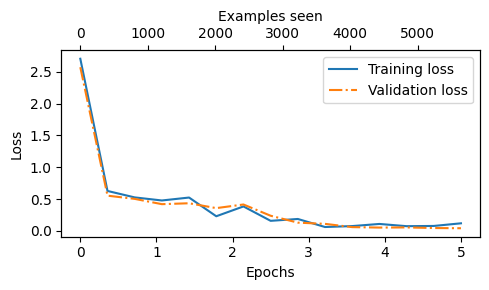

In [35]:
epochs_tensor: Tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor: Tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(
    epochs_tensor, examples_seen_tensor, train_losses, val_losses, save_plot=False
)

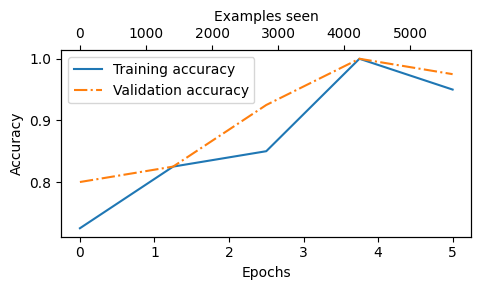

In [36]:
epochs_tensor: Tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor: Tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(
    epochs_tensor,
    examples_seen_tensor,
    train_accs,
    val_accs,
    label="accuracy",
    save_plot=False,
)

In [37]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.78%
Validation accuracy: 97.62%
Test accuracy: 97.86%


In [38]:
def classify_review(
    text: str,
    model: nn.Module,
    tokenizer: Any,  # Replace Any with the actual tokenizer type
    device: str | torch.device,
    max_length: int = None,
    pad_token_id: int = 50256,
) -> str:
    model.eval()

    input_ids: list[int] = tokenizer.encode(text)
    supported_context_length: int = model.pos_emb.weight.shape[1]
    # Truncate the input to the maximum supported length
    input_ids = input_ids[: min(max_length, supported_context_length)]

    # Pad the input to the maximum supported length
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor: torch.Tensor = torch.tensor(input_ids, device=device).unsqueeze(0)

    with torch.no_grad():
        logits: torch.Tensor = model(input_tensor)[:, -1, :]
    predicted_label: int = torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam"

In [39]:
text_1: str = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(
    classify_review(
        text_1, model, tokenizer, device, max_length=train_dataset.max_length
    )
)

1


In [40]:
text_2: str = (
    "Hey, just wanted to check if we're still on" " for dinner tonight? Let me know!"
)

print(
    classify_review(
        text_2, model, tokenizer, device, max_length=train_dataset.max_length
    )
)

0


In [42]:
text_1: str = (
    "U are a winner of $3,000. Call this number 0943 234 5678 to claim your winnings now!!!"
)

print(
    classify_review(
        text_1, model, tokenizer, device, max_length=train_dataset.max_length
    )
)

1


### Save And Load Model


```python
# Save
torch.save(model.state_dict(), "model_name.pth")


# Load
model_state_dict = torch.load("model_name.pth")
model.load_state_dict(model_state_dict)
```

In [41]:
torch.save(model.state_dict(), "models/review_classifier.pth")